# Titanic Analysis & Machine Learning

In this notebook, I dive into Kaggle's classic Titanic dataset (https://www.kaggle.com/c/titanic). The goal is to predict who is most likely to survive the ship's infamous crash. Given general passenger data (name, class status, fare amount, etc.), I create two Logisitic Regression models and two SVC models. With the help of GridSearchCV, I was able to attain 77.5% accuracy.

## Table of Contents:
* [Setup](#first-bullet)
* [Data Structure](#second-bulleta)
* [Data Exploration & Cleansing](#second-bullet)
    * [Correlations Amongst Numeric Data](#second-subbulleta)
    * [Survived](#second-subbullet)
    * [Pclass](#second-subbullet2)
    * [Name](#second-subbullet3)
    * [Sex](#second-subbullet4)
    * [Age](#second-subbullet5)
    * [SibSp](#second-subbullet6)
    * [Ticket](#second-subbullet7)
    * [Fare](#second-subbullet8)
    * [Cabin](#second-subbullet9)
    * [Embarked](#second-subbullet10)
    * [Categorical Label Encoding](#fourth-bullet)
    * [Remove Unnecessary Attributes](#fourth-bulleta)
    * [Cleansing the Test Set](#fourth-bulletb)
* [The Final Train/Test Sets](#third-bullet)
* [Model Building](#fifth-bullet)
    * [Logistic Regression](#lg)
    * [Support Vector Classification](#sv)
    * [Model Evaluation](#me)
    

## Setup <a class="anchor" id="first-bullet"></a>

First, let's load our packages/libraries.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
cd C:\TitanicData

C:\TitanicData


In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

## Data Structure<a class="anchor" id="second-bulleta"></a>

It's important to get a feel of the structure of the data you will be modeling.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Each row represents one passenger. There are 12 attributes: PassengerId, Survived (our target variable), Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, and Embarked.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are 891 instances in the data, which is fairly small. We have a mix of numeric and categorical data. We can see some fields, such as Age, Cabin, and Embarked, contain null values.

In [6]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

Our test set contains nulls for Age, Fare, and Cabin.

In [7]:
train.describe() # Shows the summary of numeric attributes

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's look at the distribution of the numeric attributes.

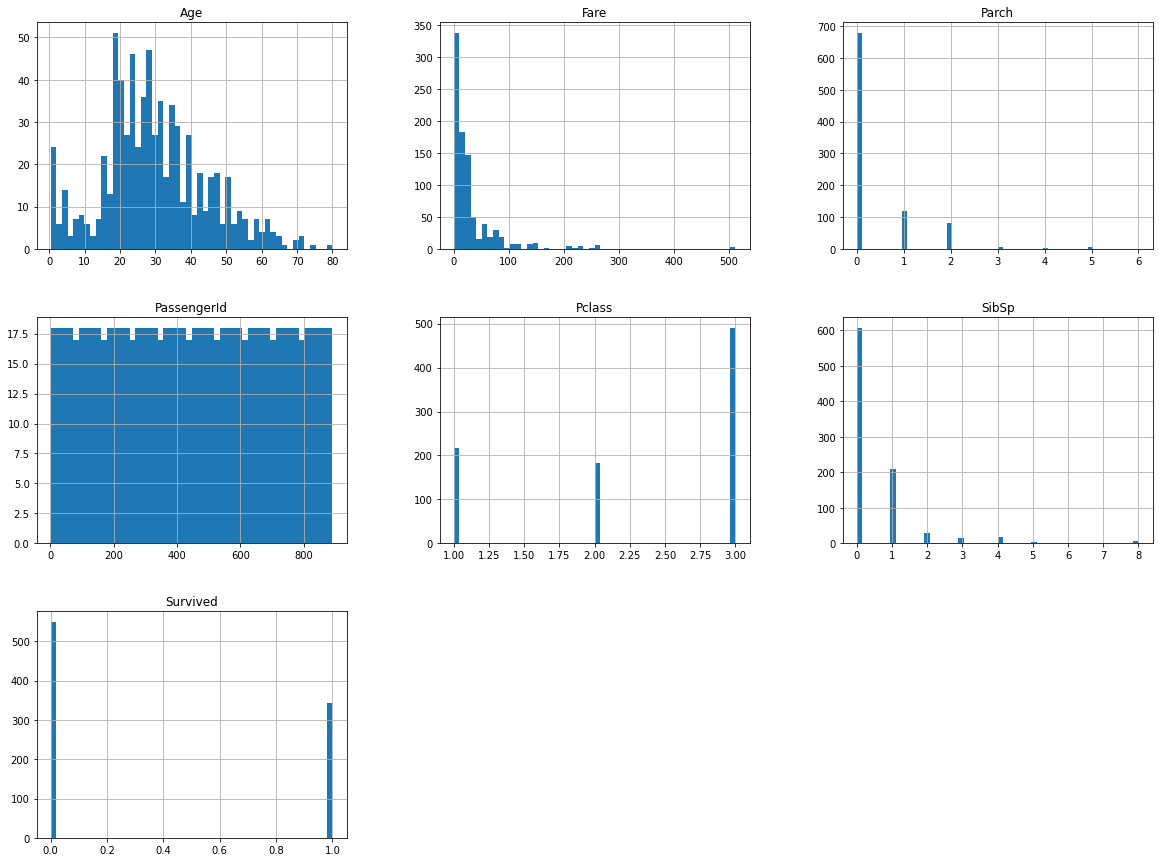

In [8]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    %matplotlib inline
    train.hist(bins=50,figsize=(20,15))
    plt.show()

We can see that these attributes have fairly different scales which we will want to adjust later on in the analysis.

Let's look at some of the categorical attributes.

In [9]:
train["Sex"].value_counts().to_frame()

,Sex
male,577
female,314


There were more males than females onboard the ship.

In [10]:
train["Ticket"].value_counts().to_frame()

,Ticket
347082,7
CA. 2343,7
1601,7
CA 2144,6
347088,6
...,...
A./5. 3235,1
350404,1
112379,1
PC 17605,1


Some passengers shared Ticket numbers.

In [11]:
train["Cabin"].value_counts().to_frame()

,Cabin
B96 B98,4
C23 C25 C27,4
G6,4
D,3
E101,3
...,...
D45,1
E58,1
A24,1
B37,1


Some passengers also shared Cabin numbers.

In [12]:
train["Embarked"].value_counts().to_frame()

,Embarked
S,644
C,168
Q,77


Most passengers boarded the Titanic at Southampton.

## Data Exploration & Cleansing <a class="anchor" id="second-bullet"></a>

In [13]:
train_copy=train.copy() # Copy the train/test sets so we can explore/clean it without harming the original sets
test_copy=test.copy()

### Correlations Amongst Numeric Data <a class="anchor" id="second-subbulleta"></a>

Let's look into possible correlations amongst Survived vs our numeric attributes.

In [14]:
train_copy["Sex_Encode"]=train_copy["Sex"].astype("category").cat.codes # Encode 'Sex' so that it is numeric

corr_matrix=train_copy.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Sex_Encode    -0.543351
Name: Survived, dtype: float64

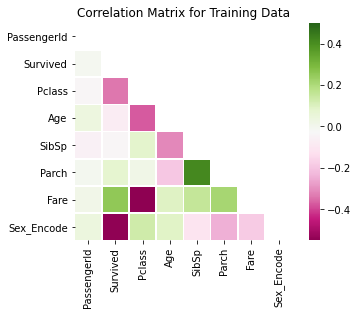

In [15]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Creates a mask for the upper triangle of the heatmap

sns.heatmap(corr_matrix, vmax=.5, mask=mask, cmap="PiYG",
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5)
plt.title('Correlation Matrix for Training Data')
plt.show()

We can see that Sex, Fare, and Pclass seem to be heavily correlated with Survived. Let's continue to explore our data and dig deeper into our attributes.

### Dependent Variable: Survived <a class="anchor" id="second-subbullet"></a>

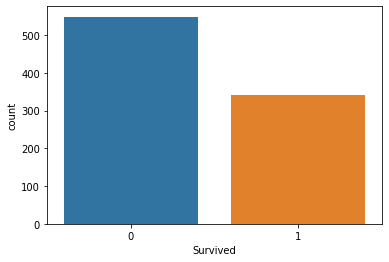

In [16]:
sns.countplot(x='Survived', data=train_copy)
plt.show()

Roughly two-thirds of passengers did not survive.

### Independent Variable: Pclass (Passenger Class) <a class="anchor" id="second-subbullet2"></a>

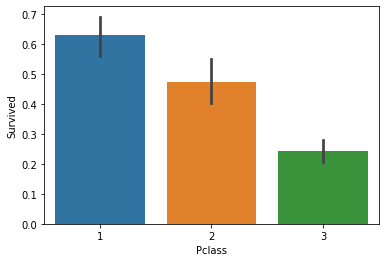

In [17]:
sns.barplot(x='Pclass', y='Survived', data=train_copy)
plt.show()

Passengers in the upper classes had a higher chance of survival. Roughly 60% of first class passengers survived compared to only 25% of third class passengers.

### Independent Variable: Name (Name of Passenger) <a class="anchor" id="second-subbullet3"></a>

'Name' by itself would not be very useful when looking at survival trends. However, many names are associated with a title (such as, Mr., Miss., or Capt.) which can be extracted. These title groupings can then be used to see possible patterns in survival.

To extract the title from the 'Name' field, I'll use regex. In the regex expression below, I am looking for any grouping of characters followed by a period. I am extracting/capturing only the characters and saving it to a new field called 'Title'.

In [18]:
def extractTitle(df):
    df[["Title"]]=df.Name.str.extract('([A-Za-z]+)\.', expand=True)

extractTitle(train_copy)
train_copy["Title"].value_counts().to_frame()

,Title
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Col,2
Major,2
Capt,1


There are 17 unique title groupings, but many groupings only have a few records in them. Let's regroup some of these less frequent titles.

In [19]:
def regroupTitle(df):
    df["Title"].replace(['Major','Col','Capt'], 'Military', inplace=True) # Regroup Military titles
    df["Title"].replace(['Miss', 'Mlle','Ms'], 'Miss', inplace=True) # Regroup Miss titles
    df["Title"].replace(['Jonkheer','Sir','Countess','Lady','Don'], 'Nobility', inplace=True) # Regroup Nobility titles
    df["Title"].replace(['Mrs', 'Mme'], 'Mrs', inplace=True) # Regroup Mrs titles
    df.drop("Name", axis=1) # Drop the Name field
    
regroupTitle(train_copy)
train_copy["Title"].value_counts().to_frame()

,Title
Mr,517
Miss,185
Mrs,126
Master,40
Dr,7
Rev,6
Military,5
Nobility,5


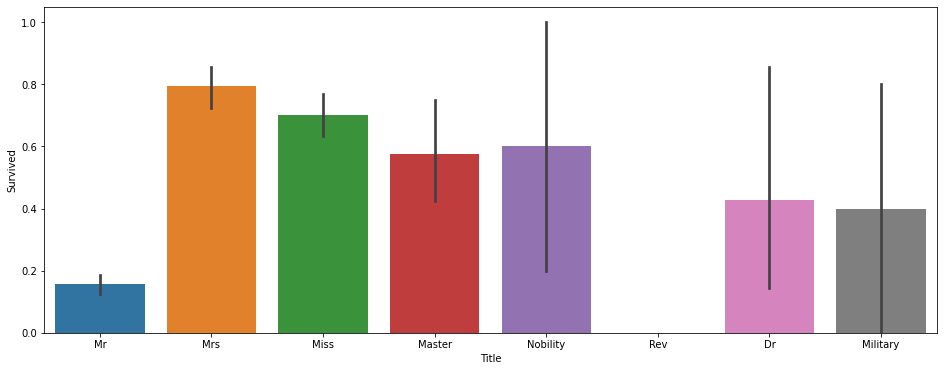

In [20]:
plt.figure(figsize=(16, 6))
sns.barplot(x='Title', y='Survived', data=train_copy)
plt.show()

Female-oriented titles (Mrs, Miss) had higher survival rates compared to male-oriented titles (Mr, Dr, Military). Titles tied to higher classes (Master, Nobility) had higher chances of survival compared to those not associated with upper classes (Mr). Finally, no individuals with the title Rev survived the crash.

### Independent Variable: Sex (Sex of Passenger) <a class="anchor" id="second-subbullet4"></a>

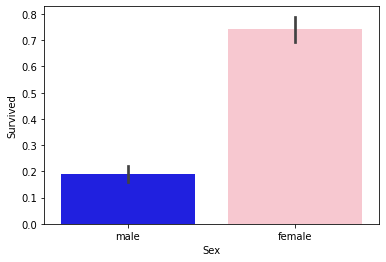

In [21]:
sns.barplot(x='Sex', y='Survived', palette=["blue", "pink"], data=train_copy)
plt.show()

We can see a clear disparity in survival rate by sex. As a whole, female passengers had a survival rate of approximately 75% whereas males had a rate of about 20%.

### Independent Variable: Age (Age of Passenger) <a class="anchor" id="second-subbullet5"></a>

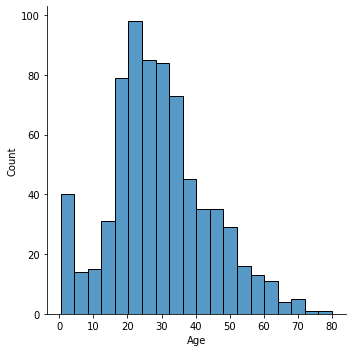

In [22]:
sns.displot(x='Age', data=train_copy)
plt.show()

Looking at the distribution of age above, we can see that passenger ages range from infant to elderly with the majority of individuals between the ages of 15 to 35.

In [23]:
def createAgeGroup(df, var):
    bins=[0, 3, 13, 20, 36, 60, 81]
    df['AgeGroup']=pd.cut(df[var], bins, labels=['Baby','Child','Teenager','Young Adult','Adult','Senior'])

createAgeGroup(train_copy, 'Age')
train_copy["AgeGroup"].value_counts().to_frame()

,AgeGroup
Young Adult,340
Adult,173
Teenager,108
Child,41
Baby,30
Senior,22


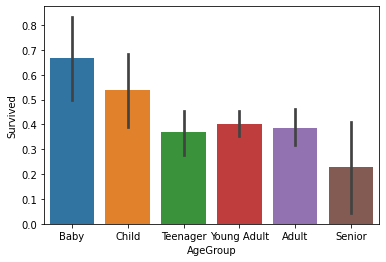

In [24]:
sns.barplot(x='AgeGroup', y='Survived', data=train_copy)
plt.show()

Baby had the highest rate of survival. Let's look at gender within each age group.

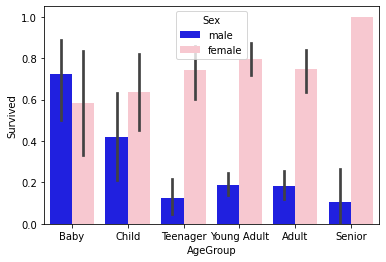

In [25]:
sns.barplot(x='AgeGroup', y='Survived', hue='Sex', palette=["blue", "pink"], data=train_copy)
plt.show()

Interestingly, males were less likely to survive in all age groupings except for Baby, where it appears that they had a higher chance of survival compared to their female counterparts. However, it's important to note the 95% confidence intervals overlap between males and females for this category. This indicates that the survival difference between genders for the Baby group are not statistically significant.

If we recall from our data stucture section, about 20% of Age is missing. Let's impute these values by grouping by Sex and Pclass and calculating the mean age.

In [26]:
def imputeAge(df_to_impute, df_to_calc_mean):
    
    group_mean_df = pd.DataFrame(df_to_calc_mean.groupby(['Pclass','Sex']).mean()).rename(columns={'Age':'AgeMean'})["AgeMean"]
    
    df_to_impute = df_to_impute.merge(group_mean_df, left_on=(['Pclass','Sex']), right_on=(['Pclass','Sex']))
    df_to_impute['Age_Imputed'] = df_to_impute['Age'].fillna(df_to_impute['AgeMean'])
    
    df_to_impute=df_to_impute.drop(columns=["AgeMean"], axis=1)
    
    return df_to_impute
    
train_copy=imputeAge(train_copy,train_copy)

createAgeGroup(train_copy, 'Age_Imputed') # Create Age Groups again based off of these imputed values

In [27]:
train_copy.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Sex_Encode       0
Title            0
AgeGroup         0
Age_Imputed      0
dtype: int64

### Independent Variables: SibSp (Count of Siblings/Spouses Aboard) & Parch (Count of Parents/Children Aboard) <a class="anchor" id="second-subbullet6"></a>

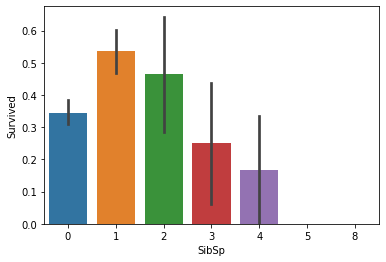

In [28]:
sns.barplot(x='SibSp', y='Survived', data=train_copy)
plt.show()

Individuals with 1 or 2 siblings/spouses onboard had a higher chance of surviving.

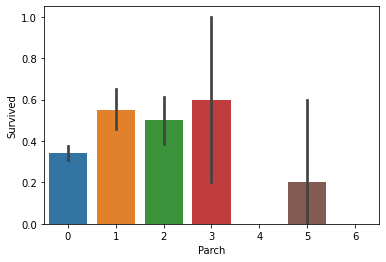

In [29]:
sns.barplot(x='Parch', y='Survived', data=train_copy)
plt.show()

Individuals with 1 to 3 parents/children onboard appeared to have a higher chance of surviving (though the confidence interval for 3 is quite widespread).

Let's create a new field called FamilyCount to see if overall family size onboard the ship has any correlation with survival.

In [30]:
def createFamilyCount(df):
    df['FamilyCount']=df['SibSp']+df['Parch']+1 # Add 1 for the individual

createFamilyCount(train_copy)
train_copy["FamilyCount"].value_counts().to_frame()

,FamilyCount
1,537
2,161
3,102
4,29
6,22
5,15
7,12
11,7
8,6


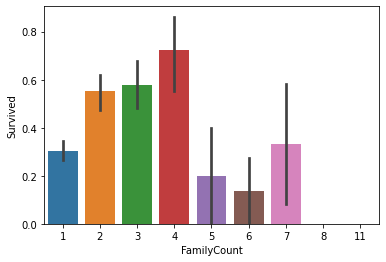

In [31]:
sns.barplot(x='FamilyCount', y='Survived', data=train_copy)
plt.show()

Individuals with a family size of 2 to 4 had the greatest survival rate. Extremely large families (8+ members) had zero chance of survival (though observation counts for these groups were low).

### Independent Variable: Ticket (Ticket Number) <a class="anchor" id="second-subbullet7"></a>

In [32]:
train_copy["Ticket"].value_counts().to_frame()

,Ticket
CA. 2343,7
347082,7
1601,7
3101295,6
CA 2144,6
...,...
SC/PARIS 2131,1
347068,1
363294,1
112379,1


Some individuals share the same ticket number. Let's look into some of these shared tickets.

In [33]:
train_copy[train_copy['Ticket']=='347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Encode,Title,AgeGroup,Age_Imputed,FamilyCount
5,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S,1,Mr,Adult,39.0,7
333,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S,1,Master,Child,4.0,7
469,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S,0,Miss,Baby,2.0,7
536,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S,0,Miss,Child,9.0,7
537,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S,0,Miss,Child,11.0,7
545,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S,0,Mrs,Adult,39.0,7
573,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S,0,Miss,Child,6.0,7


In [34]:
train_copy[train_copy['Ticket']=='CA. 2343']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Encode,Title,AgeGroup,Age_Imputed,FamilyCount
63,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,1,Master,Young Adult,26.507589,11
81,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,1,Mr,Young Adult,26.507589,11
121,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,1,Mr,Young Adult,26.507589,11
331,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,1,Mr,Young Adult,26.507589,11
479,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,0,Miss,Young Adult,21.750000,11
569,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,0,Miss,Young Adult,21.750000,11
580,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,0,Miss,Young Adult,21.750000,11


In [35]:
train_copy[train_copy['Ticket']=='1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Encode,Title,AgeGroup,Age_Imputed,FamilyCount
25,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,1,Mr,Young Adult,32.000000,1
69,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1,Mr,Young Adult,28.000000,1
191,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1,Mr,Young Adult,26.000000,1
244,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,1,Mr,Young Adult,26.507589,1
262,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,Mr,Young Adult,26.507589,1
319,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1,Mr,Young Adult,26.507589,1
326,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1,Mr,Young Adult,32.000000,1


It looks like individuals with the same ticket # are traveling together as a family or group. We can see in the output above for ticket # 1601 that none of the passengers are siblings, spouses, parents, or children of one another (their FamilyCount=1), despite traveling together on the same ticket. A quick internet search reveals that these men were colleagues (https://www.encyclopedia-titanica.org/titanic-survivor/lee-bing.html). Traveling as a group could impact survival chances. Let's create a new field for this.

In [36]:
def createTravelCount(df):
    df['TravelCount']=df.groupby('Ticket')['PassengerId'].transform('count') # Count the # of indivduals with the same Ticket #

createTravelCount(train_copy)
train_copy["TravelCount"].value_counts().to_frame()

,TravelCount
1,547
2,188
3,63
4,44
7,21
6,18
5,10


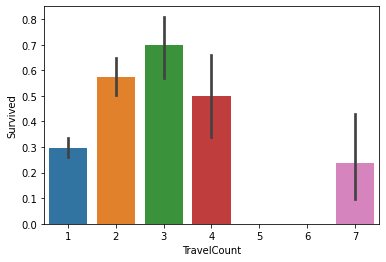

In [37]:
sns.barplot(x='TravelCount', y='Survived', data=train_copy)
plt.show()

Individuals with a travel group size between 2 and 4 had the greatest survival rate.

### Independent Variable: Fare (Fare Amount Paid) <a class="anchor" id="second-subbullet8"></a>

In [38]:
train_copy.groupby('Pclass')['Fare'].mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

As expected, the higher the class, the higher the fare.

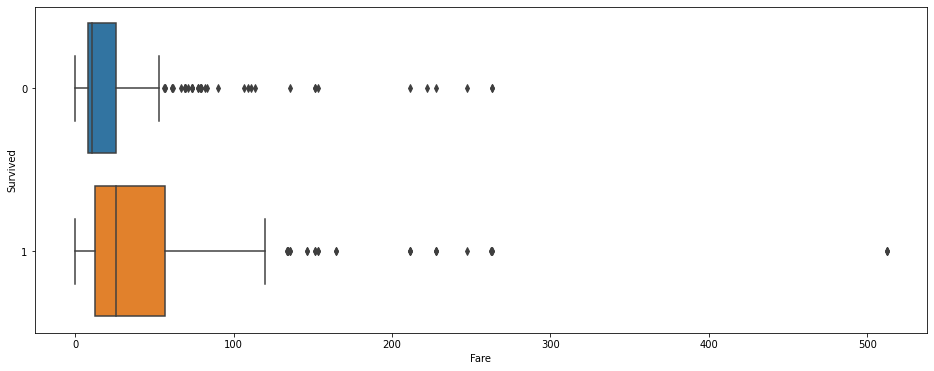

In [39]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="Fare", y="Survived", orient="h", data=train_copy)
plt.show()

The distribution of fare is higher for those that survived. In other words, amongst survivors, ticket fares were more varied when compared to the fares paid by non-survivors. However, overall, individuals who died were more likely to have lower fares.

Our test set contains cases where Fare is missing. Let's create a function that imputes null Fares with the mean Fare amount from the train set.

In [40]:
def imputeFare(df_to_impute, df_to_calc_mean):
    group_mean_df = df_to_calc_mean["Fare"].mean()
    df_to_impute['Fare_Imputed'] = df_to_impute['Fare'].fillna(group_mean_df)
    return df_to_impute

train_copy=imputeFare(train_copy, train_copy)

### Independent Variable: Cabin (Cabin Number) <a class="anchor" id="second-subbullet9"></a>

In [41]:
train_copy["Cabin"].value_counts().to_frame()

,Cabin
B96 B98,4
G6,4
C23 C25 C27,4
F2,3
F33,3
...,...
D9,1
D45,1
E58,1
A24,1


A quick Google search shows that there were 10 decks - seven of which labeled A through G (https://www.dummies.com/education/history/titanic-facts-the-layout-of-the-ship/). These appear to correspond to the letters in the cabin numbers above. Let's extract them.

In [42]:
def createCabinGroup(df):
    df['CabinGroup']=df.Cabin.str.extract('([A-Za-z]+)', expand=True)

createCabinGroup(train_copy)
train_copy["CabinGroup"].value_counts().to_frame()

,CabinGroup
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1


There is one T group which doesn't appear to be a cabin grouping. This could relate to the "Tank Top" cabin which contained the boiler and engine rooms. Let's see how survival rate varies amongst cabin grouping.

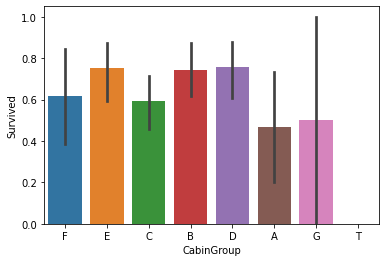

In [43]:
sns.barplot(x='CabinGroup', y='Survived', data=train_copy)
plt.show()

There appears to be a lot of variance amongst the cabin groupings when it comes to survival rates. This field has a lot of missing values which could explain this variance. Let's try grouping cabin groups together. I'd assume cabin groups relate to passenger class levels. Let's take a look.

In [44]:
train_copy['CabinRegroup'] = train_copy['CabinGroup'].fillna('U') # Set missing cabin groups to 'U' for Unknown

In [45]:
cabinclass = train_copy[['CabinRegroup','Pclass']]

In [46]:
cabinclass2=cabinclass.groupby(['CabinRegroup','Pclass']).size().to_frame('Count')
cabinclass2

Count
CabinRegroup Pclass       
A            1          15
B            1          47
C            1          59
D            1          29
             2           4
E            1          25
             2           4
             3           3
F            2           8
             3           5
G            3           4
T            1           1
U            1          40
             2         168
             3         479

We can see that Cabins A-C are all first class, and as we saw earlier, the higher the class you were, the more likely you were to survive. Let's regroup these cabin letters together according to their class ranks and look at survivability.

In [47]:
# Place T in first group since that passengar was in first class 
train_copy['CabinRegroup'] = train_copy['CabinRegroup'].replace(['A', 'B', 'C', 'D','E', 'T'], 'ABCDET') # Mostly first class
train_copy['CabinRegroup'] = train_copy['CabinRegroup'].replace(['F','G'], 'FG') # Mostly second/third
train_copy['CabinRegroup'].value_counts()

U         687
ABCDET    187
FG         17
Name: CabinRegroup, dtype: int64

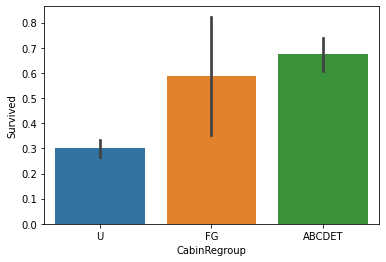

In [48]:
sns.barplot(x='CabinRegroup', y='Survived', data=train_copy)
plt.show()

We can see cabin groupings definitely impact chances of survival. Specifically, if a passenger has an unknown cabin group, it is likely that they died.

In [49]:
# Let's create a function that performs the above transformations which we can use on the test set.
def createCabinRegroup(df):
    df['CabinRegroup']=df['CabinGroup'].fillna('U') # Set missing cabin groups to 'U' for Unknown
    df['CabinRegroup'] = df['CabinRegroup'].replace(['A', 'B', 'C', 'D','E', 'T'], 'ABCDET') # Mostly first class
    df['CabinRegroup'] = df['CabinRegroup'].replace(['F','G'], 'FG') # Mostly second/third

### Independent Variable: Embarked (Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton) <a class="anchor" id="second-subbullet10"></a>

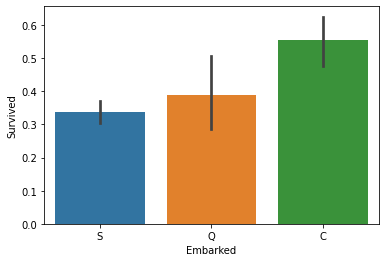

In [50]:
sns.barplot(x='Embarked', y='Survived', data=train_copy)
plt.show()

Individuals who embarked at Cherbourg had the highest rate of survival. If you recall from the Data Structure section, two rows had missing Embarked values. Let's replace these with the most frequent Embarked location.

In [51]:
train_copy.groupby(['Embarked']).agg('count')['PassengerId'] # S is most frequent.

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [52]:
def imputeEmbarked(df_to_impute, df_to_calc_mode):
    df_to_impute['Embarked_Imputed'] = df_to_impute['Embarked'].fillna('S')
    return df_to_impute

train_copy=imputeEmbarked(train_copy, train_copy)

### Categorical Label Encoding<a class="anchor" id="fourth-bullet"></a>

It's important that we encode categorical variables when building models.

In [53]:
def encodeCat(df):
    df['Sex'] = df['Sex'].astype('category').cat.codes
    df['Ticket'] = df['Ticket'].astype('category').cat.codes
    df['Title'] = df['Title'].astype('category').cat.codes
    df['AgeGroup'] = df['AgeGroup'].astype('category').cat.codes
    df['Embarked_Imputed'] = df['Embarked_Imputed'].astype('category').cat.codes
    df['CabinRegroup'] = df['CabinRegroup'].astype('category').cat.codes

encodeCat(train_copy)

### Remove Unnecessary Attributes<a class="anchor" id="fourth-bulleta"></a>

Finally, let's remove attributes that are not needed for the model building phase.

In [54]:
train_copy=train_copy.drop(columns=['Name','Age','Embarked','Sex_Encode','Fare', 'Cabin', 'CabinGroup'])

### Cleansing the Test Set<a class="anchor" id="fourth-bulletb"></a>

Let's repeat all of the transformations we performed on the train set on the test set.

In [55]:
extractTitle(test_copy)
regroupTitle(test_copy)
test_copy=imputeAge(test_copy, train)
createAgeGroup(test_copy, 'Age_Imputed')
createFamilyCount(test_copy)
createTravelCount(test_copy)
test_copy=imputeFare(test_copy, train)
createCabinGroup(test_copy)
createCabinRegroup(test_copy)
test_copy=imputeEmbarked(test_copy, train)
encodeCat(test_copy)
test_copy=test_copy.drop(columns=['Name','Age','Embarked', 'Cabin','Fare', 'Cabin', 'CabinGroup'])

In [56]:
test_copy.isna().sum()

PassengerId         0
Pclass              0
Sex                 0
SibSp               0
Parch               0
Ticket              0
Survived            0
Title               0
Age_Imputed         0
AgeGroup            0
FamilyCount         0
TravelCount         0
Fare_Imputed        0
CabinRegroup        0
Embarked_Imputed    0
dtype: int64

### The Final Train/Test Sets<a class="anchor" id="third-bullet"></a>

In [57]:
train_copy # View the final train set

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Title,AgeGroup,Age_Imputed,FamilyCount,TravelCount,Fare_Imputed,CabinRegroup,Embarked_Imputed
0,1,0,3,1,1,0,523,4,3,22.000000,2,1,7.2500,2,2
1,5,0,3,1,0,0,472,4,3,35.000000,1,1,8.0500,2,2
2,6,0,3,1,0,0,275,4,3,26.507589,1,1,8.4583,2,1
3,8,0,3,1,3,1,395,1,0,2.000000,5,4,21.0750,2,2
4,13,0,3,1,0,0,535,4,2,20.000000,1,1,8.0500,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,849,0,2,1,0,1,155,7,3,28.000000,2,3,33.0000,2,2
887,862,0,2,1,1,0,221,4,3,21.000000,2,1,11.5000,2,2
888,865,0,2,1,0,0,120,4,3,24.000000,1,1,13.0000,2,2
889,884,0,2,1,0,0,565,4,3,28.000000,1,1,10.5000,2,2


In [58]:
test_copy # View the final test set

,PassengerId,Pclass,Sex,SibSp,Parch,Ticket,Survived,Title,Age_Imputed,AgeGroup,FamilyCount,TravelCount,Fare_Imputed,CabinRegroup,Embarked_Imputed
0,892,3,1,0,0,152,0,5,34.500000,3,1,1,7.8292,2,1
1,895,3,1,0,0,147,0,5,27.000000,3,1,1,8.6625,2,2
2,897,3,1,0,0,261,1,5,14.000000,2,1,1,9.2250,2,2
3,901,3,1,2,0,269,0,5,21.000000,3,3,1,24.1500,2,2
4,902,3,1,0,0,195,0,5,26.507589,3,1,1,7.8958,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1222,2,0,0,2,285,1,6,48.000000,4,3,2,36.7500,2,2
414,1241,2,0,0,0,299,1,4,31.000000,3,1,1,21.0000,2,2
415,1253,2,0,1,1,329,1,6,24.000000,3,3,1,37.0042,2,0
416,1254,2,0,0,0,295,1,6,31.000000,3,1,2,21.0000,2,2


## Model Building <a class="anchor" id="fifth-bullet"></a>

We can now start building our models. Let's prep the train and test sets for model building.

In [59]:
features = ["Pclass", "Sex", "SibSp", "Parch", "Ticket", "Title", "Age_Imputed", 
            "AgeGroup", "FamilyCount", "TravelCount", "Fare_Imputed", "CabinRegroup", "Embarked_Imputed"]

x_train = train_copy[features]
y_train = train_copy["Survived"]

x_test = test_copy[features]
y_test=test_copy["Survived"]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((891, 13), (891,), (418, 13), (418,))

In [60]:
# Feature scaling
scaler = StandardScaler()

scaler.fit(x_train) # Scale train features
x_train2 = scaler.transform(x_train)

scaler.fit(x_test) # Scale test features
x_test2=scaler.transform(x_test)

### Logistic Regression<a class="anchor" id="lg"></a>

In [61]:
logReg=LogisticRegression(max_iter=5000) # Set max iterations to 5,000
logReg.fit(x_train2, y_train) # Fit training data to logistic regression model

print("Accuracy of logReg on train:",logReg.score(x_train2, y_train)) # Print accuracy

Accuracy of logReg on train: 0.8159371492704826


In [62]:
weights_lr = np.abs(logReg.coef_[0]) # Get absolute value of model coefficients
feature_imp_lr=np.stack((features, weights_lr), axis=1) # Join together with feature names

feature_df_lr = pd.DataFrame(feature_imp_lr, columns = ['Feature','Weight']) # Create pandas frame
feature_df_lr.sort_values(by=['Weight'], ascending=False)

,Feature,Weight
1,Sex,1.3466114601985004
0,Pclass,0.6748921354265239
7,AgeGroup,0.6230165181352765
2,SibSp,0.3244377998064087
11,CabinRegroup,0.24668215762831391
8,FamilyCount,0.22367841119768056
5,Title,0.19043708431161785
12,Embarked_Imputed,0.15328717589216354
4,Ticket,0.143650152915066
10,Fare_Imputed,0.11219827882879072


Let's fine-tune the hyperparameters via GridSearchCV.

In [63]:
param_grid = [{ 'C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'solver':['lbfgs'],
               'penalty': ['l2']},
              { 'C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'solver':['liblinear'],
               'penalty': ['l1','l2']}
             ]

# Performing the Grid Search
gs_logReg = GridSearchCV(logReg, param_grid=param_grid, cv=5, refit='Accuracy')
gs_logReg.fit(x_train2, y_train) # Fit to train

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=5000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit='Accuracy',


In [64]:
print("Best Parameters:", gs_logReg.best_params_)
print("Best Estimator:", gs_logReg.best_estimator_)
print("-----")
print("Accuracy of gs_logReg on train:", gs_logReg.score(x_train2,y_train)) # Print accuracy

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Estimator: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
-----
Accuracy of gs_logReg on train: 0.813692480359147


Let's try fitting an SVC model now.

### Support Vector Classification<a class="anchor" id="sv"></a>

In [65]:
svm_model=svm.SVC(kernel='linear')
svm_model.fit(x_train2, y_train) # Fit training data to linear SVM model

print("Accuracy of svm on train:",svm_model.score(x_train2, y_train)) # Print accuracy

Accuracy of svm on train: 0.8002244668911336


In [66]:
# Feature importance

weights = np.abs(svm_model.coef_[0]) # Get absolute value of model coefficients
feature_imp=np.stack((features, weights), axis=1) # Join together with feature names

feature_df = pd.DataFrame(feature_imp, columns = ['Feature','Weight']) # Create pandas frame
feature_df.sort_values(by=['Weight'], ascending=False)

,Feature,Weight
1,Sex,1.00859802178435
7,AgeGroup,0.2755963123196241
10,Fare_Imputed,0.19467280631799838
9,TravelCount,0.18576636044954142
0,Pclass,0.11966312849253541
2,SibSp,0.10183480501644881
5,Title,0.08242510897797217
8,FamilyCount,0.08224990837088031
4,Ticket,0.06770231200839383
6,Age_Imputed,0.06340581849236582


Like before, let's fine-tune the hyperparameters via GridSearchCV.

In [67]:
# Our grid of parameters to search
pg_svm = {'C': [0.01, 0.1, 1, 2, 3, 4, 5, 7, 9, 10], 
          'gamma': [0.001, 0.01, 0.1, 1],
          'kernel': ["linear", "rbf", "sigmoid"]}

# Performing the Grid Search
gs_svm = GridSearchCV(svm_model, param_grid=pg_svm, cv=5, refit='Accuracy')
gs_svm.fit(x_train2, y_train) # Fit to train

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 2, 3, 4, 5, 7, 9, 10],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit='Accuracy',
             return_train_score=False, scoring=None, verbose=0)

In [68]:
print("Best Parameters:", gs_svm.best_params_)
print("Best Estimator:", gs_svm.best_estimator_)
print("-----")
print("Accuracy of gs_svm on train:", gs_svm.score(x_train2,y_train)) # Print accuracy

Best Parameters: {'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimator: SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
-----
Accuracy of gs_svm on train: 0.8294051627384961


Accuracy on train is highest when using the SVC model created via GridSearchCV. Let's evaluate this model on our test set.

## Model Evaluation<a class="anchor" id="me"></a>

In [69]:
print("gs_svm score on test:", gs_svm.score(x_test2, y_test)) # Print accuracy

gs_svm score on test: 0.7751196172248804


Let's look at the confusion matrix and classfication report.

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       260
           1       0.70      0.71      0.70       158

    accuracy                           0.78       418
   macro avg       0.76      0.76      0.76       418
weighted avg       0.78      0.78      0.78       418



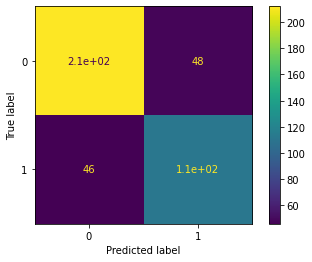

In [70]:
y_pred = gs_svm.predict(x_test2)
y_actual=y_test

plot_confusion_matrix(gs_svm, x_test2, y_test)
print(classification_report(y_actual, y_pred))

In summary, the SVC model created using GridSearchCV has an accuracy of roughly 78%. Precision is 70%, meaning that when the model predicts a passenger won't survive, it's correct 70% of the time. Recall is 71%, meaning that the model was able to correctly label 71% of all passengers who died. f1 provides us with a singular score that takes into account both precision and recall. In our case, f1 is 70%.